# Predicting Premier League 22-23 Season

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bevel.linear_ordinal_regression import OrderedLogit

We first scrap the schedule for the 22-23 season, including the results of the games already played.

In [2]:
dates_available = []
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = 'https://www.transfermarkt.com/premier-league/gesamtspielplan/wettbewerb/GB1/saison_id/2022'
pageTree = requests.get(page, headers=headers)
pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

results = pageSoup.find_all("td", {"class": "zentriert hauptlink"})
hometeams = pageSoup.find_all("td", {"class": "text-right no-border-rechts hauptlink"})
awayteams = pageSoup.find_all("td", {"class": "zentriert no-border-rechts"})
entries = []
for i in range(len(results)):
    

    ght = results[i].text[1:-1].split(':')[0]
    if ght == '-':
        ght = np.nan
    else:
        ght = int(ght)
    aht = results[i].text[1:-1].split(':')[1]
    if aht == '-':
        aht = np.nan
    else:
        aht = int(aht)
        
    htname = hometeams[i].find_all("a")[0]['title']
    atname = awayteams[i].find_all("a")[0]['title']

    entries.append((htname, atname, ght, aht))
df = pd.DataFrame(entries, columns=['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])
df.to_csv('data/EPL Schedule 22-23.csv', index=False)

Then we define our model based on a 18-19 season. We could use a more recent season (19-20 or 20-21) but chose not as they were affected by COVID-19 pandemic.

In [3]:
def get_df(season):
    df = pd.read_csv(f'data/EPL Games {season}.csv')
    # Drop the columns we will not use
#     df.drop(['Div', 'HTHG',
#            'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
#            'AC', 'HY', 'AY', 'HR', 'AR', 'BWH', 'BWD',
#            'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA',
#            'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD',
#            'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
#            'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
#            'PSCH', 'PSCD', 'PSCA'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['logTMratio'] = np.log(df['HTMValue']/df['ATMValue'])
    df['win.ord'] = np.where(df['FTHG']>df['FTAG'], 2, np.where(df['FTAG']>df['FTHG'], 0, 1))
    return df

In [4]:
df_train = get_df('18-19')

In [5]:
def predict2223(df_train, keys):
    ol = OrderedLogit()
    ol.fit(df_train[keys], df_train['win.ord'])
    # We gather the data for the 22-23 season
    df_test = pd.read_csv(f'data/EPL Schedule 22-23.csv')
    df_TM = pd.read_csv('raw_data/transfermarkt/TMValueEngland.csv')
    # Select the most recent date before the start of the league
    df_TM = df_TM[df_TM['Date']=='2022-08-01']
    # Add the TMValue for each Team
    df_TM_home = df_TM.drop(columns=['Date']).rename(columns={'Team':'HomeTeam', 'TMValue':'HTMValue'})
    df_TM_away = df_TM.drop(columns=['Date']).rename(columns={'Team':'AwayTeam', 'TMValue':'ATMValue'})
    df_test = df_test.merge(df_TM_home, on=['HomeTeam'], how='left').merge(df_TM_away, on=['AwayTeam'], how='left')
    # Compute the logarithm of the ratio of the TMValues
    df_test['logTMratio'] = np.log(df_test['HTMValue']/df_test['ATMValue'])
    # Define the ordinal variable that represents the game outcome
    df_test['win.ord'] = np.where(df_test['FTHG']>df_test['FTAG'], 2, np.where(df_test['FTAG']>df_test['FTHG'], 0, 1))
    df_test.loc[df_test['FTHG'].isna(),'win.ord'] = np.nan
    
    pred_prob = ol.predict_probabilities(df_test[keys])
    df_test['pred'] = ol.predict_class(df_test[keys])
    df_test['p_loss_ht'] = pred_prob[:,0]
    df_test['p_draw_ht'] = pred_prob[:,1]
    df_test['p_win_ht'] = pred_prob[:,2]
    return df_test

In [6]:
df_pred = predict2223(df_train, ['logTMratio'])

Now that we have our estimated probabilities for the outcome of each game, we can simulate the outcome of the season by simulating each game individually. 

In [7]:
n_sim = 100000 # number of times the season is simulated
n_games = len(df_pred)
p_loss_ht = np.repeat(np.array(df_pred['p_loss_ht']).reshape(-1,1),n_sim, axis=1)
p_draw_ht = np.repeat(np.array(df_pred['p_draw_ht']).reshape(-1,1),n_sim, axis=1)
p_win_ht = np.repeat(np.array(df_pred['p_win_ht']).reshape(-1,1),n_sim, axis=1)

sim = np.random.uniform(size=n_games*n_sim)
sim = sim.reshape((n_games, n_sim))

outcomes = np.ones((n_games, n_sim), dtype=int)
outcomes[sim < p_win_ht+p_loss_ht] = 0
outcomes[sim < p_win_ht] = 2

The games that have already been played are not simulated and the actual outcome is store

In [8]:
games_played = df_pred['FTHG'].notna()
outcomes_games_played = np.array(df_pred.loc[games_played,'win.ord']).reshape(-1,1)
outcomes[games_played,:] = np.repeat(outcomes_games_played, n_sim, axis=1)

For each team we store the total points in the season for each simulation.

In [9]:
teams = df_pred['HomeTeam'].unique()
pts_sim = {}
for team_name in teams:    
    home_games = df_pred['HomeTeam']==team_name
    away_games = df_pred['AwayTeam']==team_name
    home_points = outcomes[home_games,:].copy()
    home_points = np.where(outcomes[home_games,:]==2, 3, home_points)
    away_points = outcomes[away_games,:].copy()
    away_points = np.where(outcomes[away_games,:]==2, 0, away_points)
    away_points = np.where(outcomes[away_games,:]==0, 3, away_points)
    pts = home_points.sum(axis=0)+away_points.sum(axis=0)
    pts_sim[team_name] = pts

We determine the final position of each team in each simulation.

In [10]:
table = []
for team_name in teams:
    table.append(pts_sim[team_name])
pos_sim_temp = scipy.stats.rankdata(-np.array(table),axis=0, method='ordinal')

We count how many teams each team finishes in each possible position which allows us to approximate the probabilities of finishing 1st, 2nd, etc for each team.

In [11]:
prob_sim = {}
pos_sim = {}
for i, name in enumerate(teams):
    pos_sim[name] = pos_sim_temp[i,:]
    prob_sim[name] = (pos_sim[name] == np.arange(1,21).reshape(-1,1)).mean(axis=1)

With these probability we can easily compute the probability of team wining the Premier League, qualifying to the Uefa Champions League and being relegated.

In [12]:
entries = []
for name in teams:
    exp_pts = np.mean(pts_sim[name])
    win_pl = np.round(100*prob_sim[name][0],2)
    qlf_ucl = sum(100*prob_sim[name][:4])
    relegated = sum(100*prob_sim[name][-3:])
    entries.append((name, np.round(relegated), np.round(qlf_ucl), np.round(win_pl), np.round(exp_pts,2)))
df_simulations = pd.DataFrame(entries, columns=['Team', 'Relegated', 'Qualify UCL', 'Win PL', 'Pts']).sort_values(
    ['Win PL','Qualify UCL', 'Relegated'], ascending = [False, False, True])

We add the logos of the teams to our table.

In [13]:
logos = {
    'AFC Bournemouth': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/AFC-Bournemouth-Logo-PNG.png',
    'Arsenal FC': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Arsenal-Logo-PNG.png',
    'Aston Villa': 'https://teamcolorcodes.com/wp-content/uploads/2018/08/Aston-Villa-FC-Logo-PNG.png',
    'Brentford FC': 'https://seeklogo.com/images/B/brentford-fc-logo-E928FFBD93-seeklogo.com.png',
    'Brighton & Hove Albion': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Brighton-Hove-Albion-Logo-PNG.png',
    'Chelsea FC': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Chelsea-Logo-PNG.png',
    'Crystal Palace': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Crystal-Palace-FC-Logo-PNG.png',
    'Everton FC': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Everton-FC-Logo-PNG.png',
    'Fulham FC':'https://cdn.freebiesupply.com/logos/large/2x/fulham-fc-1-logo-png-transparent.png',
    'Leeds United': 'https://spng.subpng.com/20181202/hpe/kisspng-leeds-united-f-c-elland-road-leeds-united-vs-bren-5c0442bcc2aa31.1058369415437831007974.jpg',
    'Leicester City': 'https://teamcolorcodes.com/wp-content/uploads/2021/04/Leicester-City-Football-Club-Logo-PNG.png',
    'Liverpool FC': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Liverpool-FC-Logo-PNG.png',
    'Manchester City': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Manchester-City-FC-Logo-PNG.png',
    'Manchester United': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Manchester-United-Logo-PNG.png',
    'Newcastle United': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Newcastle-United-FC-Logo-PNG.png',
# alternative link 'Nottingham Forest': 'https://upload.wikimedia.org/wikipedia/commons/6/61/Nottingham_Forest_logo.png',
    'Nottingham Forest': 'https://cdn.freebiesupply.com/logos/large/2x/nottingham-forest-fc-logo-svg-vector.svg',
    'Southampton FC': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Southampton-FC-Logo-PNG.png',
    'Tottenham Hotspur': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/Tottenham-Hotspur-Logo-PNG.png',
    'West Ham United': 'https://teamcolorcodes.com/wp-content/uploads/2017/11/West-Ham-United-Logo-PNG.png',
    'Wolverhampton Wanderers':'https://teamcolorcodes.com/wp-content/uploads/2018/08/Wolverhampton-Wanderers-F.C-Logo-PNG.png'
}
df_simulations[''] = ['<img src="'+ logos[team] + '", width="20px", height="20px" > ' for team in df_simulations['Team']]

We finally stylize our table.

In [14]:
df_style = df_simulations[['','Team', 'Relegated', 'Qualify UCL', 'Win PL', 'Pts']].style.background_gradient(cmap='YlOrRd', vmin=0, vmax=100, subset=['Relegated', 'Qualify UCL', 'Win PL'])
df_style = df_style.format((
    {'Relegated':lambda x:  "{:2.0f}%".format(x) if x>0 else '< 1%',
     'Qualify UCL':lambda x:  "{:2.0f}%".format(x) if x>0 else '< 1%',
     'Win PL':lambda x:  "{:2.0f}%".format(x) if x>0 else '< 1%',
     'Pts':'{:2.0f}'}))
df_style = df_style.set_properties(**{'text-align': 'center'})
df_style = df_style.set_properties(**{'text-align': 'left'}, subset=['Team'])
df_style = df_style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df_style.hide(axis='index')

,Team,Relegated,Qualify UCL,Win PL,Pts
,Manchester City,< 1%,92%,48%,80
,Tottenham Hotspur,< 1%,72%,16%,74
,Arsenal FC,< 1%,68%,13%,74
,Chelsea FC,< 1%,58%,8%,72
,Manchester United,< 1%,56%,8%,71
,Liverpool FC,< 1%,50%,6%,71
,Aston Villa,< 1%,2%,< 1%,56
,Leicester City,2%,1%,< 1%,52
,Everton FC,3%,< 1%,< 1%,49
,Brighton & Hove Albion,3%,< 1%,< 1%,50


In [15]:
import dataframe_image as dfi
import os
os.makedirs('assets',exist_ok=True)
dfi.export(df_style, 'assets/premier_league_predictions.png');

/home/campus/tiago.saldanhasalvador@MAIL.MCGILL.CA/.conda/envs/stats/lib/python3.10/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0918/131206.413881:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0918/131206.435423:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0918/131207.766304:INFO:headless_shell.cc(660)] Written to file /tmp/tmpsdcexq_t/temp.png.


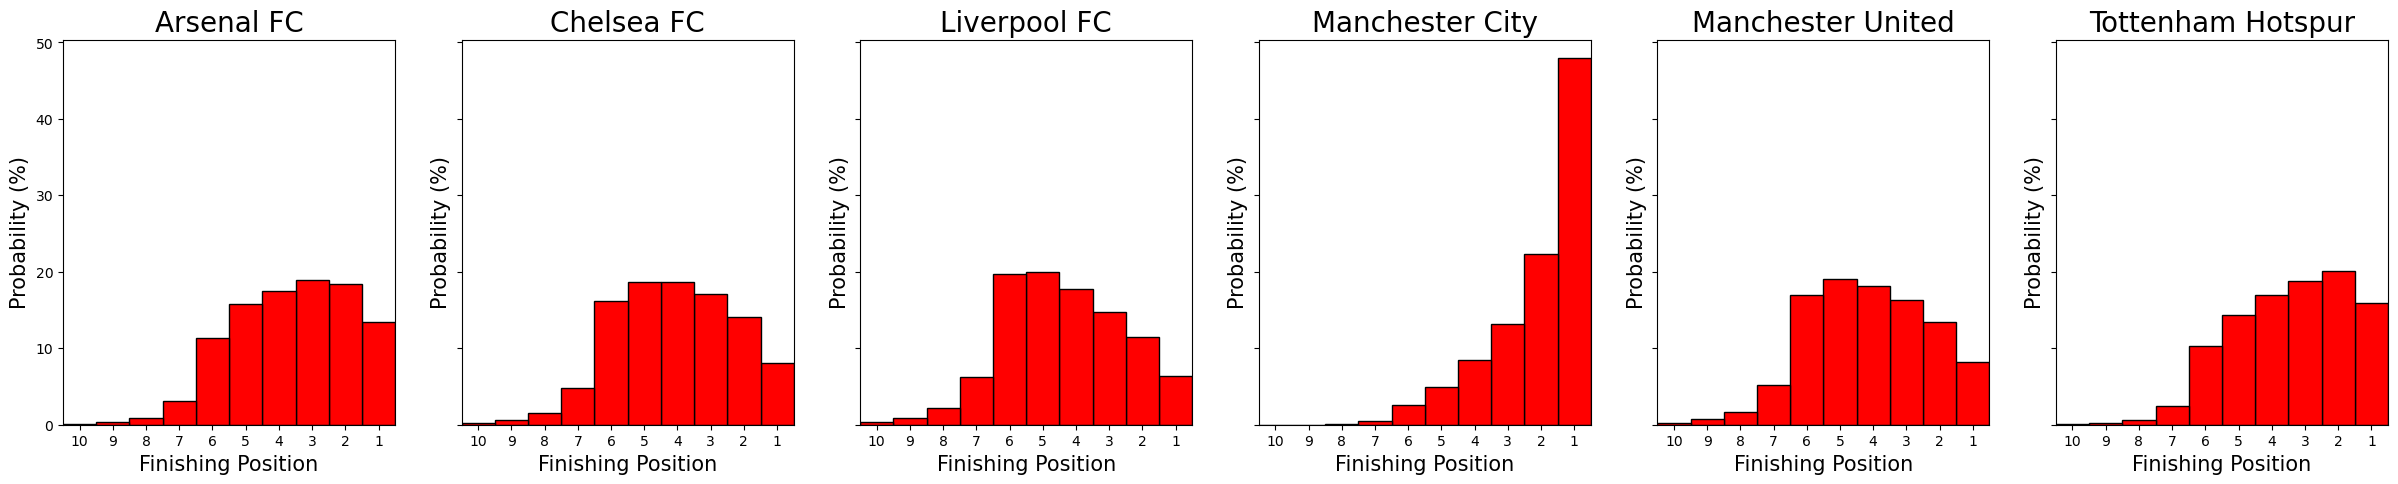

In [16]:
big_six = ['Arsenal FC', 'Chelsea FC', 'Liverpool FC', 'Manchester City', 'Manchester United', 'Tottenham Hotspur']

fig, axs = plt.subplots(1, len(big_six), figsize=(30,5), sharey=True)
for i, name in enumerate(big_six):
    axs[i].bar(-np.arange(20)-0.5, prob_sim[name]*100, width=1, edgecolor='black', color='r')
    axs[i].set_xticks(-np.arange(0,20,1)-0.5);
    axs[i].set_xticklabels(np.arange(0,20,1)+1);
    axs[i].set_title(name, fontsize=20)
    axs[i].set_xlim(-10,0)
    axs[i].set_xlabel('Finishing Position', fontsize=15)
    axs[i].set_ylabel('Probability (%)', fontsize=15)
fig.savefig('assets/big_six_end_season_probabilities.png', dpi=fig.dpi, bbox_inches='tight')